In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set(rc={'figure.figsize':(11.7,8.27)})
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

In [141]:
#df = pd.read_csv('train.csv', chunksize = 10000)
#first_chunk = next(df)



train = pd.read_csv("train.csv",
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
train.head(5)
pd.options.display.precision = 15


In [3]:
train.columns

Index(['acoustic_data', 'time_to_failure'], dtype='object')

In [142]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


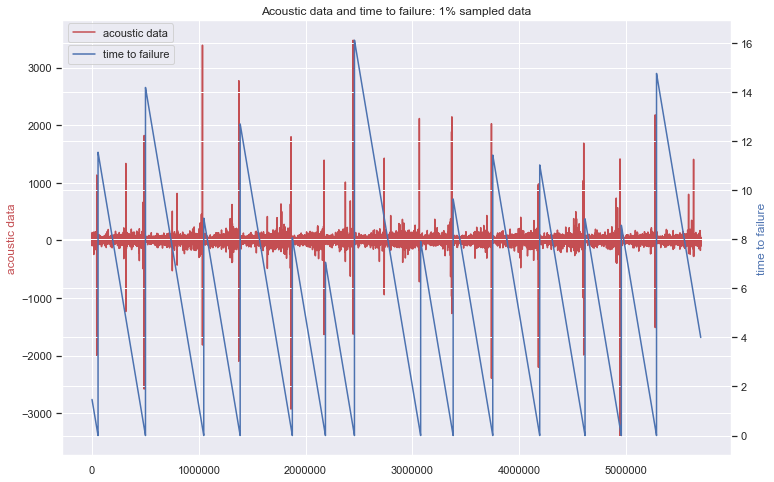

In [146]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [147]:
# # Create a training file with simple derived features
# rows = 150_000
# # shift_step for augmented training set
# #shift_step = int(np.floor(rows / 2))
# segments = int(np.floor(train.shape[0] / rows))
# #segments_augmented = 2*segments - 1

# X_train = pd.DataFrame(index=range(segments_augmented), dtype=np.float64,
#                        columns=['ave', 'std', 'max', 'min','q95','q99', 'q05','q01'])
# y_train = pd.DataFrame(index=range(segments_augmented), dtype=np.float64,
#                        columns=['time_to_failure'])


# for segment in tqdm(range(segments)):
# #     for do_shift in [False,True]:        
# #         if(do_shift):
# #             shift = shift_step
# #             idx = segments + segment            
# #             if(segment==segments-1): #last segment would be incomplete for the shifted version
# #                 continue
# #         else:
# #             shift = 0
# #             idx = segment
        
#         #seg = train.iloc[segment*rows+shift:segment*rows+shift+rows]
#         seg = train.iloc[segment*rows:segment*rows+rows]
#         x = seg['acoustic_data'].values
#         y = seg['time_to_failure'].values[-1]

#         y_train.loc[idx, 'time_to_failure'] = y

#         X_train.loc[idx, 'ave'] = x.mean()
#         X_train.loc[idx, 'std'] = x.std()
#         X_train.loc[idx, 'max'] = x.max()
#         X_train.loc[idx, 'min'] = x.min()
#         X_train.loc[idx, 'q95'] = np.quantile(x,0.95)
#         X_train.loc[idx, 'q99'] = np.quantile(x,0.99)
#         X_train.loc[idx, 'q05'] = np.quantile(x,0.05)
#         X_train.loc[idx, 'q01'] = np.quantile(x,0.01)

    
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
#     X_train.loc[idx, 'q95'] = np.quantile(x,0.95)
#     X_train.loc[idx, 'q99'] = np.quantile(x,0.99)
#     X_train.loc[idx, 'q05'] = np.quantile(x,0.05)
#     X_train.loc[idx, 'q01'] = np.quantile(x,0.01)
    
    
    


100%|██████████| 3801/3801 [00:06<00:00, 579.73it/s]


In [148]:
type(X_train)

pandas.core.frame.DataFrame

In [149]:
print(X_train.shape)
print(y_train.shape)
print(type(X_train))

(3801, 4)
(3801, 1)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
#X_train = pd.DataFrame(X_train)

In [150]:
X_train.columns

Index(['ave', 'std', 'max', 'min'], dtype='object')

In [151]:
y_train.columns

Index(['time_to_failure'], dtype='object')

In [152]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)


In [153]:
print(X_train.shape)
print(y_train.shape)
print(type(X_train_scaled.shape))

(3801, 4)
(3801, 1)
<class 'tuple'>


In [154]:
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)


In [155]:
lm = LinearRegression()

In [156]:
lm.fit(X_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [ ]:
# The coefficients
print('Coefficients: \n', lm.coef_)

In [157]:
predictions = lm.predict(X_train_scaled)

In [158]:


score = mean_absolute_error(y_train.values.flatten(), predictions)
print(f'Score: {score:0.3f}')



Score: 2.957


In [159]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_train, predictions))
print('MSE:', metrics.mean_squared_error(y_train, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, predictions)))

MAE: 2.956825088408074
MSE: 12.914563143074421
RMSE: 3.5936837845133818


Text(0,0.5,'Predicted Y')

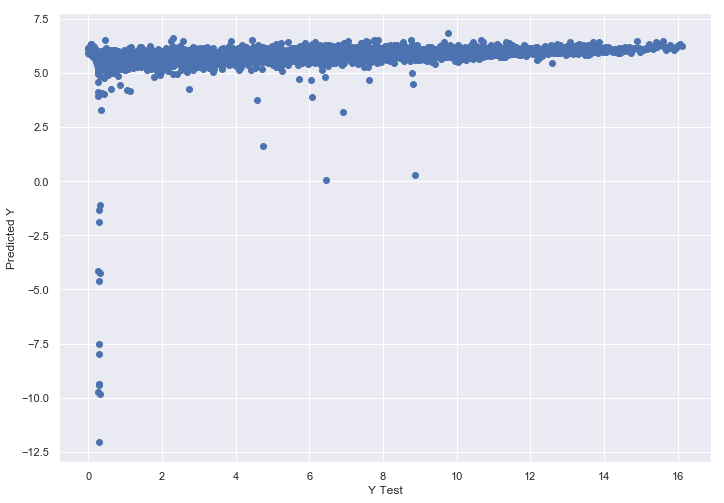

In [160]:
plt.scatter(y_train,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [ ]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')

In [ ]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [ ]:
for seg_id in X_test.index:
    seg = pd.read_csv('test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()


In [ ]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = lm.predict(X_test_scaled)
submission.to_csv('submission.csv')

In [163]:
X = X_train[['ave', 'std', 'max', 'min']]

y = y_train['time_to_failure']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30)

In [164]:
print(X.shape)
print(X.dtypes)
print(y.dtypes)
print(y.shape)
print(type(X))
print(type(y))

(3801, 4)
ave    float64
std    float64
max    float64
min    float64
dtype: object
float64
(3801,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [165]:
from sklearn.model_selection import cross_val_predict, GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

In [169]:
rfr = RandomForestRegressor(random_state=0, n_estimators = 600, criterion='mae')

In [170]:
cv_scores = cross_val_score(rfr, X, y, cv = 5)


In [171]:
print(cv_scores)

[0.35159857 0.13882322 0.1924142  0.43019322 0.21663528]


In [172]:
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [173]:
predictions = rfr.predict(X_test)

In [174]:
print(predictions)

[3.74594341 4.79903273 6.67922688 ... 3.78783811 4.22329911 7.83274637]


In [175]:
mean_absolute_error(y_test, predictions)

2.3580617600200857

In [176]:
from sklearn.metrics import classification_report,confusion_matrix

In [177]:
print(rfr.score(X_test, y_test))

0.31987351260392116


Text(0,0.5,'Predicted Y')

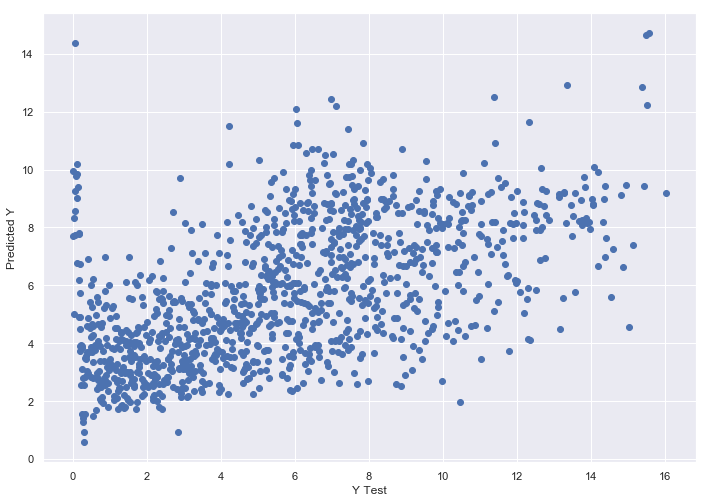

In [178]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [179]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')

In [180]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [181]:
for seg_id in X_test.index:
    seg = pd.read_csv('test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()


In [182]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = rfr.predict(X_test)
submission.to_csv('submission2.csv')

In [183]:
!which kaggle

/Users/hari/anaconda3/envs/NSSdatascience/bin/kaggle
